In [1]:
import pdb

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import radvel

import rvsearch
from rvsearch import utils

%matplotlib inline

# Compile Specmatch (hybrid of synth. and emp.) parameters for the Legacy sample.

## Take specmatch-synth data, use for all appropriate stars. Take specmatch-emp data, use for Teff < 5000. Also load legacy starlist.

In [2]:
legacy = pd.read_csv('../legacy.txt', names=['Name'])
legacy_names = list(legacy['Name'])
legacy_names = [legacy_names[i].lower() for i in np.arange(len(legacy_names))]

# Make specmatch names lowercase, to match the legacy target list file.
specmatch_syn = pd.read_csv('specmatch_results_syn.csv')
specmatch_syn['name'] = specmatch_syn['name'].str.lower()
specmatch_s_names = specmatch_syn.name.unique()

specmatch_emp = pd.read_csv('specmatch_results_emp.csv')
specmatch_emp['name'] = specmatch_emp['name'].str.lower()
specmatch_e_names = specmatch_emp.name.unique()

In [3]:
bad_pars = specmatch_emp.query('name in @legacy_names and (iso_parallax == "NaN" or \
                                iso_parallax > 1 or iso_parallax < 0)')

In [4]:
specmatch_emp.query('name == "gl803"')

,Unnamed: 0,id,name,obs,obstime,run,runnum,expnum,outdir,outdir_mtime,...,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,iso_fe,iso_fe_err1,iso_fe_err2,iso_parallax,iso_parallax_err1,iso_parallax_err2
541,543,GL803_rj20.21,gl803,rj20.21,2006-07-14 13:31,j20,20.0,NaN,/data/user/doppler/public_html/smemp/results/G...,1.575716e+09,...,-66.423876,4.720209,0.032043,-0.028578,0.194019,0.090981,-0.088891,11.711739,1.138057,-0.984543


In [5]:
bad_pars.name

173         gl406
175         gl406
285        191408
286        191408
287        191408
288        191408
289        191408
295        200968
296        200968
297        200968
298        200968
299        200968
302        201092
541         gl803
959        75732b
960        75732b
961        75732b
1081      s122446
1210      195019b
1211      195019b
1443      s130811
1444      s130811
1728      s122446
1729      s122446
2409       192263
2410       192263
4732      120476a
4999      147379b
5123       153557
5366       s11844
6070       103095
7339       105113
7347    hip114914
7372       219542
7390     s101438b
7582       188510
7649       217004
7923       gl4063
Name: name, dtype: object

In [6]:
bad_pars = bad_pars.query('name != "gl406"')

In [7]:
len(np.unique(bad_pars.name))

21

## Save all specmatch/isoclassify properties for legacy stars. Take median values. 

In [8]:
specmatch_emp.query('name == "hip84099"').iso_parallax

7860    0.083146
Name: iso_parallax, dtype: float64

In [9]:
intersection = list(set(specmatch_syn.columns) & set(specmatch_emp.columns))
print(intersection)

['iso_parallax_err2', 'iso_logage_err1', 'iso_logg', 'iso_teff', 'iso_age_err1', 'kmag_err', 'fe', 'iso_radius_err1', 'teff_err', 'expnum', 'iso_teff_err2', 'iso_logage', 'iso_teff_err1', 'outdir', 'obs', 'iso_mass', 'teff', 'iso_mass_err1', 'iso_logage_err2', 'iso_parallax_err1', 'iso_mass_err2', 'iso_radius_err2', 'logg_err', 'name', 'iso_logg_err1', 'runnum', 'fe_err', 'id', 'iso_parallax', 'run', 'iso_fe', 'iso_logg_err2', 'outdir_mtime', 'iso_radius', 'logg', 'iso_age', 'iso_age_err2', 'iso_fe_err2', 'iso_fe_err1', 'obstime', 'Unnamed: 0', 'kmag']


## Specmatch-emp does not produce vsini, and only returns iso_ labels for some parameters.

In [10]:
select_syn_columns = ['obs','name', 'teff', 'teff_err', 'logg', 
                      'logg_err', 'fe', 'fe_err', 'vsini', 'vsini_err',
                      'iso_mass', 'iso_mass_err1', 'iso_mass_err2',
                      'iso_radius', 'iso_radius_err1', 'iso_radius_err2', 
                      'iso_logage', 'iso_logage_err1', 'iso_logage_err2', 
                      'iso_age', 'iso_age_err1', 'iso_age_err2', 
                      'iso_teff', 'iso_teff_err1', 'iso_teff_err2',
                      'iso_logg', 'iso_logg_err1', 'iso_logg_err2', 
                      'iso_fe', 'iso_fe_err1', 'iso_fe_err2',
                      'iso_parallax', 'iso_parallax_err1', 
                      'iso_parallax_err2'
                     ]

select_emp_columns = ['obs','name', 'teff', 'teff_err', 'logg', 
                      'logg_err', 'fe', 'fe_err', 'radius', 'radius_err',
                      'iso_mass', 'iso_mass_err1', 'iso_mass_err2',
                      'iso_radius', 'iso_radius_err1', 'iso_radius_err2', 
                      'iso_logage', 'iso_logage_err1', 'iso_logage_err2', 
                      'iso_age', 'iso_age_err1', 'iso_age_err2', 
                      'iso_teff', 'iso_teff_err1', 'iso_teff_err2',
                      'iso_logg', 'iso_logg_err1', 'iso_logg_err2', 
                      'iso_fe', 'iso_fe_err1', 'iso_fe_err2',
                      'iso_parallax', 'iso_parallax_err1', 
                      'iso_parallax_err2'
                     ]

In [11]:
specmatch_syn = specmatch_syn[select_syn_columns]
specmatch_emp = specmatch_emp[select_emp_columns]
len(select_emp_columns)

34

## Merge synthetic and empirical tables.

In [12]:
smsyn = specmatch_syn.copy()
smemp = specmatch_emp.copy()

# As of 1/8/20, add three dummy rows to smemp, for the three stars with bad smemp results.
smemp.loc[smemp.shape[0]] = ['rj169.108', '134439', 4916.8, 100, 5.18, 
                             0.1, -1.27686978327, 0.06, 0.63, 0.034,
                             0.54, 0.035, -0.35, 0.63, 0.034, -0.034, 
                             9.5, 4., -4., 10**9.5, 5*10**8.5, -5*10**8.5,
                             4916.8, 100, -100, 5.18, 0.1, -0.1, 
                             -1.28, 0.06, -0.06, 
                             0.0339871, 4.3e-05,
                             4.3e-05]


smemp.loc[smemp.shape[0]] = ['rj169.109', '134440', 4744.2, 100, 5.21, 
                             0.1, -1.27686978327, 0.06, 0.61, 0.034,
                             0.62, 0.034, -0.034, 0.61, 0.034, -0.034, 
                             9.5, 4., -4., 10**9.5, 5*10**8.5, -5*10**8.5,
                             4744.2, 100., -100., 5.21, 0.1, -0.1, 
                             -1.277, 0.06, -0.06, 
                             0.033796, 4.8e-05,
                             4.8e-05]

smemp.loc[smemp.shape[0]] = ['rj238.334', 'hip106924', 4916.8, 100, 5.365, 
                             0.1, -1.27686978327, 0.06, 0.9, 0.2,
                             0.9, 0.2, -0.2, 0.9, 0.2, -0.2, 
                             9.5, 4., -4., 10**9.5, 5*10**8.5, -5*10**8.5,
                             4916.8, 100., -100., 5.365, 0.1, -0.1, 
                             -1.277, 0.06, -0.06, 
                             0.014976, 3.0e-05,
                             3.0e-05]

smemp.columns = smemp.columns.map(lambda x: str(x) + '_emp')
merge = smsyn.merge(smemp, left_on='obs', right_on='obs_emp')

# Remove superfluous name columns.
merge = merge.drop(columns=['name_emp'])
merge = merge.dropna(axis='columns', how='all')

In [13]:
smemp.query('name_emp == "hip109388"')

,obs_emp,name_emp,teff_emp,teff_err_emp,logg_emp,logg_err_emp,fe_emp,fe_err_emp,radius_emp,radius_err_emp,...,iso_teff_err2_emp,iso_logg_emp,iso_logg_err1_emp,iso_logg_err2_emp,iso_fe_emp,iso_fe_err1_emp,iso_fe_err2_emp,iso_parallax_emp,iso_parallax_err1_emp,iso_parallax_err2_emp
31,rj02.945,hip109388,3516.0,70.0,4.5,1.5,0.43,0.09,0.464,0.1,...,-29.820199,4.790591,0.009395,-0.008278,0.396326,0.051368,-0.071636,0.1136,0.000046,0.000046
32,rj02.946,hip109388,3517.0,70.0,4.5,1.5,0.43,0.09,0.464,0.1,...,-30.159929,4.790628,0.009301,-0.008309,0.396030,0.051525,-0.071701,0.1136,0.000046,0.000046
33,rj02.947,hip109388,3508.0,70.0,4.5,1.5,0.40,0.09,0.461,0.1,...,-30.796006,4.791144,0.009366,-0.008092,0.382941,0.058260,-0.072404,0.1136,0.000046,0.000046


In [14]:
smemp.query('name_emp == "gj9522a"').iso_parallax_emp

9835    0.030761
Name: iso_parallax_emp, dtype: float64

In [15]:
merge.query('name == "134439"').iso_mass_emp

4744    0.54
Name: iso_mass_emp, dtype: float64

## Drop all non-legacy stars.

In [16]:
merge_legacy = merge[merge['name'].isin(legacy_names)]
specmatch_syn = None
specmatch_emp = None
smsyn = None
smemp = None
merge = None
print('Whole legacy sample:', len(merge_legacy.name.unique()))
bastards = np.setdiff1d(legacy_names, merge_legacy.name.unique())
print('Floozies:', bastards)

Whole legacy sample: 720
Floozies: []


In [17]:
nandex = np.argwhere(np.isnan(merge_legacy.iso_mass))[:,0]
merge_legacy.loc[nandex]

,obs,name,teff,teff_err,logg,logg_err,fe,fe_err,vsini,iso_mass,...,iso_teff_err2_emp,iso_logg_emp,iso_logg_err1_emp,iso_logg_err2_emp,iso_fe_emp,iso_fe_err1_emp,iso_fe_err2_emp,iso_parallax_emp,iso_parallax_err1_emp,iso_parallax_err2_emp
97,rj06.1068,50692,5795.703531,100.0,4.273946,0.1,-0.166673,0.06,0.000079,0.902052,...,-77.147515,4.285368,0.030549,-0.026202,-0.212513,0.086701,-0.083677,0.057242,0.000101,0.000101
370,rj13.2107,24496,5538.824446,100.0,4.474011,0.1,0.040199,0.06,0.000014,0.924969,...,-78.487230,4.408565,0.034392,-0.025191,0.025054,0.082719,-0.080294,0.048811,0.000047,0.000047
425,rj14.529,225213,4810.761878,100.0,4.591527,0.1,-0.798971,0.06,14.554340,0.000000,...,-30.344293,4.901167,0.008193,-0.009248,-0.401761,0.082987,-0.083428,0.230133,0.000060,0.000060
556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
654,rj23.1107,8389,5288.129790,100.0,4.182341,0.1,0.451892,0.06,0.219128,0.943806,...,-83.196770,4.482102,0.025063,-0.032958,0.418079,0.049032,-0.060417,0.033211,0.000047,0.000047
952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1109,rj55.1986,95735,4884.543888,100.0,4.946311,0.1,-0.860420,0.06,4.146142,0.000000,...,-31.590330,4.893054,0.008469,-0.009914,-0.346023,0.084128,-0.085242,0.392640,0.000670,0.000670
1339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Make unique, median dataframe for stellar parameters. Save.

In [18]:
merge_legacy.query('name == "192263"')

,obs,name,teff,teff_err,logg,logg_err,fe,fe_err,vsini,iso_mass,...,iso_teff_err2_emp,iso_logg_emp,iso_logg_err1_emp,iso_logg_err2_emp,iso_fe_emp,iso_fe_err1_emp,iso_fe_err2_emp,iso_parallax_emp,iso_parallax_err1_emp,iso_parallax_err2_emp
2406,rj96.974,192263,5014.385342,100.0,4.623583,0.1,0.074851,0.06,0.802998,0.820755,...,-99.745187,4.524084,0.048517,-0.957571,0.064024,0.088873,-0.091298,-1.0,-1.0,-1.0
2407,rj96.975,192263,5014.351552,100.0,4.621564,0.1,0.073431,0.06,0.705980,0.820322,...,-100.232191,4.528472,0.040156,-0.993731,0.054127,0.089575,-0.090276,-1.0,-1.0,-1.0


In [19]:
merge_legacy_good = merge_legacy.query('(iso_parallax_emp > 0 and iso_parallax_emp < 1) \
                                        or name in @bad_pars.name')
len(merge_legacy_good)

1844

In [20]:
specmatch_legacy = merge_legacy_good.groupby('name', as_index=False).median().reset_index()
len(specmatch_legacy)

720

In [21]:
specmatch_legacy[['name', 'iso_mass', 'teff_emp', 'fe', 'iso_parallax_emp']].query('iso_parallax_emp == -1')

,name,iso_mass,teff_emp,fe,iso_parallax_emp
18,105113,1.054412,5925.0,-0.098582,-1.0
65,120476a,0.741904,4595.0,0.020773,-1.0
141,147379b,0.614948,3446.0,-0.870897,-1.0
269,191408,0.639764,4956.0,-0.506482,-1.0
272,192263,0.820538,4938.5,0.074141,-1.0
283,195019b,0.635248,4003.5,-0.246549,-1.0
296,200968,0.874188,5154.0,0.123388,-1.0
339,217004,1.037938,5810.0,-0.009236,-1.0
354,219542,1.042849,5687.0,0.189741,-1.0
540,75732b,0.647277,3244.0,-0.958133,-1.0


In [22]:
specmatch_legacy.query('iso_mass_emp == 0').name

298       201092
396        25329
633       gl528b
652    hip103269
664     hip16404
Name: name, dtype: object

## Select syn or emp for each star, save preferred parameters. Teff_emp < 4,700 K.

In [23]:
legacy_syn = specmatch_legacy.query('teff_emp >= 4700')
legacy_emp = specmatch_legacy.query('teff_emp < 4700')

legacy_syn['method'] = 'syn'
legacy_emp['method'] = 'emp'

legacy_syn['teff_c'] = legacy_syn['teff']
legacy_emp['teff_c'] = legacy_emp['teff_emp']
legacy_syn['teff_err_c'] = legacy_syn['teff_err']
legacy_emp['teff_err_c'] = legacy_emp['teff_err_emp']

legacy_syn['fe_c'] = legacy_syn['iso_fe']
legacy_emp['fe_c'] = legacy_emp['iso_fe_emp']
legacy_syn['fe_err_c'] = 0.5*(legacy_syn['iso_fe_err1'] - legacy_syn['iso_fe_err2'])
legacy_emp['fe_err_c'] = 0.5*(legacy_emp['iso_fe_err1_emp'] - legacy_emp['iso_fe_err2_emp'])

legacy_syn['logg_c'] = legacy_syn['iso_logg']
legacy_emp['logg_c'] = legacy_emp['iso_logg_emp']
legacy_syn['logg_err_c'] = 0.5*(legacy_syn['iso_logg_err1'] - legacy_syn['iso_logg_err2'])
legacy_emp['logg_err_c'] = 0.5*(legacy_emp['iso_logg_err1_emp'] - legacy_emp['iso_logg_err2_emp'])

legacy_syn['radius_c'] = legacy_syn['iso_radius']
legacy_emp['radius_c'] = legacy_emp['iso_radius_emp']
legacy_syn['radius_err_c'] = 0.5*(legacy_syn['iso_radius_err1'] - legacy_syn['iso_radius_err2'])
legacy_emp['radius_err_c'] = 0.5*(legacy_emp['iso_radius_err1_emp'] - legacy_emp['iso_radius_err2_emp'])

legacy_syn['mass_c'] = legacy_syn['iso_mass']
legacy_emp['mass_c'] = legacy_emp['iso_mass_emp']
legacy_syn['mass_err_c'] = 0.5*(legacy_syn['iso_mass_err1'] - legacy_syn['iso_mass_err2'])
legacy_emp['mass_err_c'] = 0.5*(legacy_emp['iso_mass_err1_emp'] - legacy_emp['iso_mass_err2_emp'])

In [24]:
np.amin(legacy_emp.mass_c)

0.0

In [25]:
#legacy_syn.iso_logg_err2
legacy_syn.logg_err_c

0      0.029609
1      0.017508
2      0.031621
3      0.021678
4      0.059031
         ...   
704    0.021148
711    0.028274
712    0.008407
716    0.109487
717    0.086889
Name: logg_err_c, Length: 537, dtype: float64

In [26]:
print(len(legacy_syn), len(legacy_emp))

537 183


In [27]:
#specmatch_legacy.to_csv('legacy_specmatch_medians.csv')
legacy_choice = legacy_syn.append(legacy_emp).reset_index()

#Institute temporary fixes for 201092, hip16404, 153557.
legacy_choice.loc[legacy_choice.name == '201092', 'mass_c'] = 0.64
legacy_choice.loc[legacy_choice.name == '201092', 'mass_err_c'] = 0.02
legacy_choice.loc[legacy_choice.name == '201092', 'logg_c'] = 4.65
legacy_choice.loc[legacy_choice.name == '201092', 'logg_err_c'] = 0.1

legacy_choice.loc[legacy_choice.name == 'hip16404', 'logg_c'] = 4.75
legacy_choice.loc[legacy_choice.name == 'hip16404', 'logg_err_c'] = 0.1

legacy_choice.loc[legacy_choice.name == '153557', 'logg_c'] = 4.58
legacy_choice.loc[legacy_choice.name == '153557', 'logg_err_c'] = 0.1
legacy_choice.loc[legacy_choice.name == '153557', 'mass_c'] = 0.7945
legacy_choice.loc[legacy_choice.name == '153557', 'mass_err_c'] = 0.031

G = 6.67*10**-8
def logg(M, R):
    return np.log10(G*(M*1.99*10**33)/(R*6.96*10**10)**2)

legacy_choice.loc[legacy_choice.name == '134439', 'mass_c'] = 0.54
legacy_choice.loc[legacy_choice.name == '134439', 'mass_err_c'] = 0.05
legacy_choice.loc[legacy_choice.name == '134439', 'radius_c'] = 0.63
legacy_choice.loc[legacy_choice.name == '134439', 'radius_err_c'] = 0.05
legacy_choice.loc[legacy_choice.name == '134439', 'logg_c'] = logg(0.54, 0.63)
legacy_choice.loc[legacy_choice.name == '134439', 'logg_err_c'] = 0.01
legacy_choice.loc[legacy_choice.name == '134439', 'fe_c'] = 0.54
legacy_choice.loc[legacy_choice.name == '134439', 'fe_err_c'] = 0.05

legacy_choice.loc[legacy_choice.name == '134440', 'mass_c'] = 0.62
legacy_choice.loc[legacy_choice.name == '134440', 'mass_err_c'] = 0.05
legacy_choice.loc[legacy_choice.name == '134440', 'radius_c'] = 0.61
legacy_choice.loc[legacy_choice.name == '134440', 'radius_err_c'] = 0.05
legacy_choice.loc[legacy_choice.name == '134440', 'logg_c'] = logg(0.62, 0.61)
legacy_choice.loc[legacy_choice.name == '134440', 'logg_err_c'] = 0.01
legacy_choice.loc[legacy_choice.name == '134440', 'fe_c'] = 0.54
legacy_choice.loc[legacy_choice.name == '134440', 'fe_err_c'] = 0.05

legacy_choice.loc[legacy_choice.name == 'hip106924', 'mass_c'] = 0.9
legacy_choice.loc[legacy_choice.name == 'hip106924', 'mass_err_c'] = 0.05
legacy_choice.loc[legacy_choice.name == 'hip106924', 'radius_c'] = 0.9
legacy_choice.loc[legacy_choice.name == 'hip106924', 'radius_err_c'] = 0.05
legacy_choice.loc[legacy_choice.name == 'hip106924', 'logg_c'] = logg(0.9, 0.9)
legacy_choice.loc[legacy_choice.name == 'hip106924', 'logg_err_c'] = 0.01
legacy_choice.loc[legacy_choice.name == 'hip106924', 'fe_c'] = -1.67
legacy_choice.loc[legacy_choice.name == 'hip106924', 'fe_err_c'] = 0.06


# Using synthetic results for these, they seem fine and smemp crashed on these spectra.
legacy_choice.loc[legacy_choice.name == 'gl528b', 'mass_c'] = 0.7
legacy_choice.loc[legacy_choice.name == 'gl528b', 'mass_err_c'] = 0.03
legacy_choice.loc[legacy_choice.name == 'gl528b', 'radius_c'] = 0.679
legacy_choice.loc[legacy_choice.name == 'gl528b', 'radius_err_c'] = 0.024
legacy_choice.loc[legacy_choice.name == 'gl528b', 'logg_c'] = 4.62
legacy_choice.loc[legacy_choice.name == 'gl528b', 'logg_err_c'] = 0.02
legacy_choice.loc[legacy_choice.name == 'gl528b', 'fe_c'] = -0.0464
legacy_choice.loc[legacy_choice.name == 'gl528b', 'fe_err_c'] = 0.0612

legacy_choice.loc[legacy_choice.name == '201092', 'mass_c'] = 0.623
legacy_choice.loc[legacy_choice.name == '201092', 'mass_err_c'] = 0.018
legacy_choice.loc[legacy_choice.name == '201092', 'radius_c'] = 0.623
legacy_choice.loc[legacy_choice.name == '201092', 'radius_err_c'] = 0.007
legacy_choice.loc[legacy_choice.name == '201092', 'logg_c'] = 4.65
legacy_choice.loc[legacy_choice.name == '201092', 'logg_err_c'] = 0.015
legacy_choice.loc[legacy_choice.name == '201092', 'fe_c'] = -0.395
legacy_choice.loc[legacy_choice.name == '201092', 'fe_err_c'] = 0.054

In [29]:
np.amin(legacy_choice.mass_c)

0.104346462381

In [30]:
legacy_choice.query('radius_c == 0')[['name', 'teff_c', 'radius_c', 'radius_err_c', 
                                    'mass_c', 'mass_err_c', 'logg_c', 'logg_err_c',
                                    'fe_c', 'fe_err_c', 'teff_c']]

,name,teff_c,radius_c,radius_err_c,mass_c,mass_err_c,logg_c,logg_err_c,fe_c,fe_err_c,teff_c


In [31]:
legacy_choice.to_csv('legacy_specmatch_medians.csv')

In [60]:
legacy_choice.query('name == "95735"')[['name', 'teff_c', 'mass_c', 'mass_err_c',  
                                        'radius_c', 'radius_err_c']]

,name,teff_c,mass_c,mass_err_c,radius_c,radius_err_c
616,95735,3513.0,0.391846,0.008168,0.369083,0.006667


## Clean house.

In [61]:
spec_syn = specmatch_legacy.query('teff_emp > 4700')
spec_emp = specmatch_legacy.query('teff_emp <= 4700')

In [62]:
print(len(spec_syn), len(spec_emp))

537 183


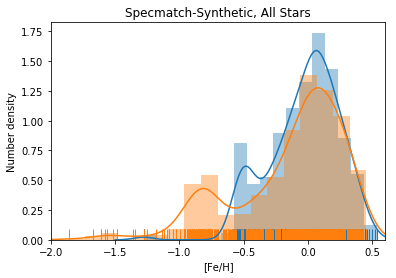

In [63]:
ax = sns.distplot(specmatch_legacy['fe_emp'], bins=18, rug=True)
ax.set(xlabel='[Fe/H]', ylabel='Number density')
ax.set_title('Specmatch-Empirical, All Stars')
ax.set_xlim([-2, 0.6])

fig = ax.get_figure()
fig.savefig('specmatch_metallicity_histogram_emp_all.pdf')

ax2 = sns.distplot(specmatch_legacy['fe'], bins=18, rug=True)
ax2.set(xlabel='[Fe/H]', ylabel='Number density')
ax2.set_title('Specmatch-Synthetic, All Stars')
ax2.set_xlim([-2, 0.6])

fig2 = ax2.get_figure()
fig2.savefig('specmatch_metallicity_histogram_syn_all.pdf')

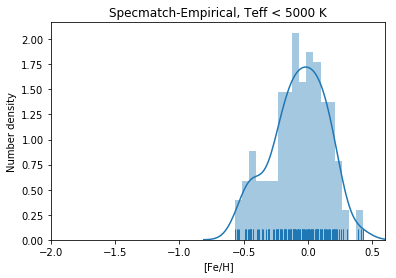

In [64]:
ax = sns.distplot(spec_emp['fe_emp'], bins=18, rug=True)
ax.set(xlabel='[Fe/H]', ylabel='Number density')
ax.set_title('Specmatch-Empirical, Teff < 5000 K')
ax.set_xlim([-2, 0.6])

fig = ax.get_figure()
fig.savefig('specmatch_metallicity_histogram_emp.pdf')

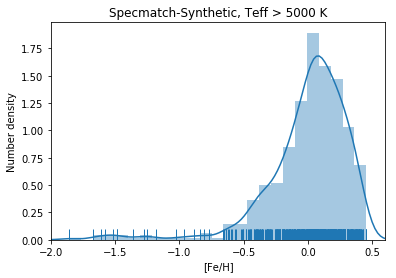

In [65]:
#[~np.isnan(spec_syn['fe'])]
ax = sns.distplot(spec_syn['fe'], bins=25, rug=True)
ax.set(xlabel='[Fe/H]', ylabel='Number density')
ax.set_title('Specmatch-Synthetic, Teff > 5000 K')
ax.set_xlim([-2, 0.6])

fig = ax.get_figure()
fig.savefig('specmatch_metallicity_histogram_synthetic.pdf')

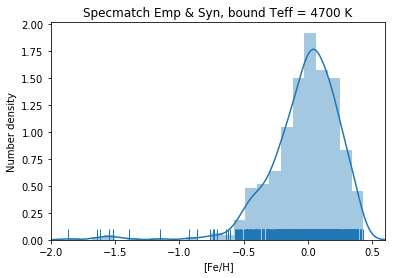

In [66]:
fe_all = spec_syn['iso_fe'].tolist() + spec_emp['fe_emp'].tolist()
#[~np.isnan(fe_all)]
ax = sns.distplot(fe_all, bins=25, rug=True)
ax.set(xlabel='[Fe/H]', ylabel='Number density')
ax.set_title('Specmatch Emp & Syn, bound Teff = 4700 K')
ax.set_xlim([-2, 0.6])

fig = ax.get_figure()
fig.savefig('specmatch_metallicity_histogram_all.pdf')

In [28]:
low_metals = specmatch_legacy.loc[specmatch_legacy.fe < -0.6]
len(low_metals)

131

In [127]:
low_metals[['name', 'fe', 'iso_mass']]
#low_metals[np.isnan(low_metals['iso_mass'])]
#low_metals.loc[low_metals.type=='emp']

,name,fe,iso_mass
5,101259,-0.650287,0.903295
19,104800,-0.678264,0.762383
49,114762,-0.638020,0.781896
66,119850,-0.860407,0.567113
75,122303,-0.805588,0.579293
104,1326,-0.803214,0.601743
105,1326b,-0.746541,0.648751
150,147379b,-1.001291,0.584672
209,165222,-0.845757,0.564814
235,173739,-0.965543,0.589445


NameError: name 'cut' is not defined

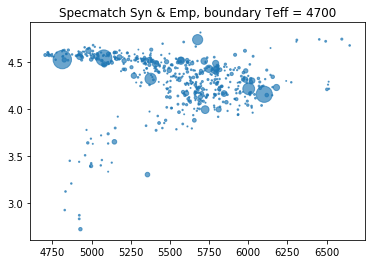

In [29]:
fig, ax = plt.subplots()

ax.scatter(spec_syn['teff_emp'], spec_syn['iso_logg'], 
           alpha=0.66, s=3*np.exp(-3*specmatch_legacy['fe']),
           label='Spec-Syn, $\propto e^{-[Fe/H]}$')

ax.set_title('Specmatch Syn & Emp, boundary Teff = 4700')
ax.scatter(spec_emp['teff_emp'], spec_emp['iso_logg'], 
           s=3*np.exp(-3*cut['fe']), 
           alpha=0.66, label='Spec-Emp')
ax.set_xlabel('Teff (K, empirical)')
ax.set_ylabel('log(g) (cm/s$^2$, synthetic)')
ax.set_ylim([4.9, 2.5])
ax.set_xlim([6700, 3000])
ax.legend()

#print(cut['name teff logg fe vsini'.split()])
fig.savefig('main_sequence_all.pdf')

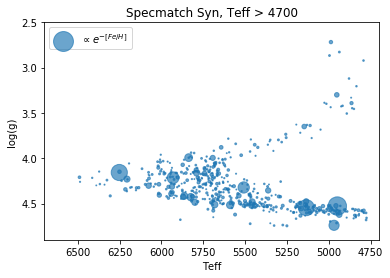

In [30]:
fig, ax = plt.subplots()

ax.scatter(spec_syn['teff'], spec_syn['iso_logg'], 
           alpha=0.66, s=3*np.exp(-3*specmatch_legacy['fe']),
           label='$\propto e^{-[Fe/H]}$')

ax.set_title('Specmatch Syn, Teff > 4700')
#ax.scatter(spec_emp['teff_emp'], spec_emp['iso_logg'], s=np.exp(-3*cut['fe']), 
#           alpha=0.66, label='Specmatch-Emp')
ax.set_xlabel('Teff')
ax.set_ylabel('log(g)')
ax.set_ylim([4.9, 2.5])
ax.set_xlim([6700, 4700])
ax.legend()

fig.savefig('main_sequence_syn.pdf')

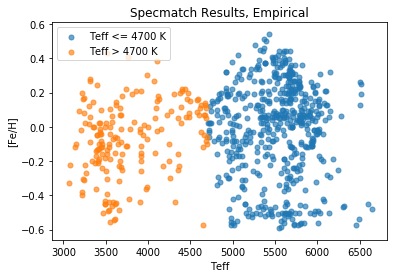

In [31]:
fig, ax = plt.subplots()

ax.scatter(spec_syn['teff_emp'], spec_syn['fe_emp'], 
           alpha=0.66, label='Teff <= 4700 K')
#s=np.exp(-3*synth['fe']),
ax.scatter(spec_emp['teff_emp'], spec_emp['fe_emp'], 
           alpha=0.66, label='Teff > 4700 K')

ax.set_title('Specmatch Results, Empirical')
ax.set_xlabel('Teff')
ax.set_ylabel('[Fe/H]')
#ax.set_ylim([4.9, 2.5])
ax.legend()

#print(cut['name teff logg fe vsini'.split()])
fig.savefig('specmatch_divide_all_emp.pdf')

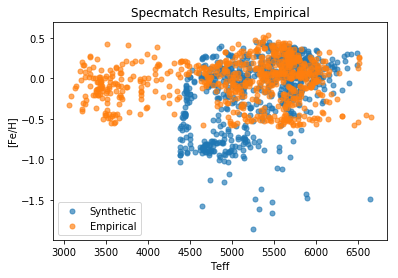

In [32]:
fig, ax = plt.subplots()

ax.scatter(specmatch_legacy['teff'], specmatch_legacy['fe'], 
           alpha=0.66, label='Synthetic')
#s=np.exp(-3*synth['fe']),
ax.scatter(specmatch_legacy['teff_emp'], specmatch_legacy['fe_emp'], 
           alpha=0.66, label='Empirical')

ax.set_title('Specmatch Results, Empirical')
ax.set_xlabel('Teff')
ax.set_ylabel('[Fe/H]')
#ax.set_ylim([4.9, 2.5])
ax.legend()

#print(cut['name teff logg fe vsini'.split()])
fig.savefig('specmatch_divide_diff.pdf')

## Select stars that are hotter than 4700 K and have significantly different Syn/Emp results .

### Use difference of 1-sigma first, whichever error is smaller (synth).

In [161]:
diff = np.absolute(specmatch_legacy.fe - specmatch_legacy.fe_emp)
suspicious_1 = specmatch_legacy.query('@diff > fe_err and teff_emp > 4700')

In [162]:
len(suspicious_1)

192

In [168]:
diff_teff = [suspicious_1['teff'], suspicious_1['teff_emp']]
diff_fe   = [suspicious_1['fe'], suspicious_1['fe_emp']]

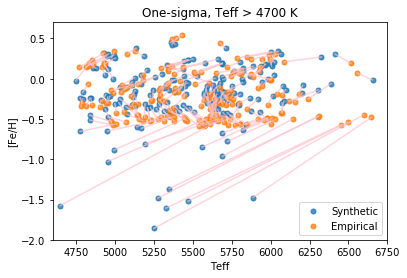

In [188]:
fig, ax = plt.subplots()

ax.plot(diff_teff, diff_fe, c='pink', alpha=0.66)
ax.scatter(suspicious_1['teff'], suspicious_1['fe'], 
           alpha=0.8, label='Synthetic')
ax.scatter(suspicious_1['teff_emp'], suspicious_1['fe_emp'], 
           alpha=0.8, label='Empirical')

ax.set_title('One-sigma, Teff > 4700 K')
ax.set_xlabel('Teff')
ax.set_ylabel('[Fe/H]')
ax.set_xlim([4600, 6750])
ax.set_ylim([-2, 0.7])
ax.legend()

#print(cut['name teff logg fe vsini'.split()])
fig.savefig('specmatch_suspicious_diff_1.pdf')

## Too broad. Let's use a 3-sigma cut.

In [180]:
suspicious_3 = specmatch_legacy.query('@diff > 3*fe_err and teff_emp > 4700').reset_index()
len(suspicious_3)

29

In [191]:
suspicious_3[['name', 'vsini', 'teff', 'teff_emp', 'fe', 'fe_emp', 'fe_err', 'fe_err_emp']]

,name,vsini,teff,teff_emp,fe,fe_emp,fe_err,fe_err_emp
0,136352,1.363507e+00,5652.518786,5611.0,-0.260514,-0.510,0.06,0.09
1,136925,2.164483e-06,5652.950765,5647.0,-0.231090,-0.450,0.06,0.09
2,150433,4.193689e-07,5591.149756,5636.0,-0.298446,-0.500,0.06,0.09
3,157214,2.652227e-07,5617.084806,5650.0,-0.319763,-0.510,0.06,0.09
4,165401,7.870893e-07,5795.524189,5727.0,-0.324675,-0.570,0.06,0.09
5,170174,4.184085e+00,4987.126031,4929.0,0.000478,0.190,0.06,0.09
6,188510,2.490748e-08,5274.702941,6310.0,-1.483160,-0.460,0.06,0.09
7,19034,1.552343e-07,5412.876273,5542.0,-0.396489,-0.590,0.06,0.09
8,193901,4.436639e-07,5689.876179,6142.0,-0.964251,-0.500,0.06,0.09
9,199476,1.801494e+00,5439.156673,5539.0,-0.329628,-0.510,0.06,0.09


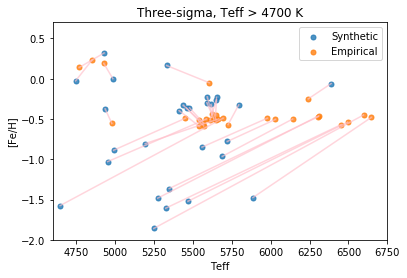

In [189]:
fig, ax = plt.subplots()

diff_teff_3 = [suspicious_3['teff'], suspicious_3['teff_emp']]
diff_fe_3   = [suspicious_3['fe'], suspicious_3['fe_emp']]

ax.plot(diff_teff_3, diff_fe_3, c='pink', alpha=0.66)
ax.scatter(suspicious_3['teff'], suspicious_3['fe'], 
           alpha=0.8, label='Synthetic')
ax.scatter(suspicious_3['teff_emp'], suspicious_3['fe_emp'], 
           alpha=0.8, label='Empirical')

ax.set_title('Three-sigma, Teff > 4700 K')
ax.set_xlabel('Teff')
ax.set_ylabel('[Fe/H]')
ax.set_xlim([4600, 6750])
ax.set_ylim([-2, 0.7])
ax.legend()

#print(cut['name teff logg fe vsini'.split()])
fig.savefig('specmatch_suspicious_diff_3.pdf')